In [40]:
%cd maze-dataset
!pip install -r requirements.txt


[WinError 2] 지정된 파일을 찾을 수 없습니다: 'maze-dataset'
c:\Users\sean2\바탕 화면\workspace\mdp\maze-dataset


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [41]:
!pip install jaxtyping

In [60]:
from maze_dataset import MazeDataset, MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators

grid_n = 5
cfg = MazeDatasetConfig(
    name="fixed_start_end_example",
    grid_n=grid_n,            # 미로 크기 (5x5)
    n_mazes=4,                # 미로 4개 생성
    maze_ctor=LatticeMazeGenerators.gen_dfs,  # DFS 기반 미로 생성
    maze_ctor_kwargs=dict(do_forks=True),     # fork(분기) 허용 여부
    endpoint_kwargs=dict(
        allowed_start=[(0, 0)],                   # 왼쪽 위 (0,0) 고정
        allowed_end=[(grid_n - 1, grid_n - 1)],   # 오른쪽 아래 (4,4) 고정
        # 필요 시 deadend_start=True 등 옵션도 가능
    ),
)

dataset = MazeDataset.from_config(cfg)

# 실제 미로 하나 확인
m = dataset[0]
print(m.as_ascii(show_endpoints=True))  # ASCII 형태로 시각화


###########
#SXXXX  # #
# ###X# # #
#   #X#   #
#####X#####
#XXXXX#   #
#X### ### #
#X#     # #
#X####### #
#XXXXXXXXE#
###########


In [57]:
# visual representation as ascii art
print(m.as_ascii())

#####################
# # # # # # # # # # #
#####################
# # # # # # # # #XXX#
#################X#X#
# # # # # # # # #X#X#
#################X#X#
# # # #XXXXXXXXXXX#E#
#######X########### #
# #XXXXX#     # # # #
###X######### ##### #
# #XXXXXXXXX#   # # #
###########X### ### #
# # # #SXXXX# #     #
#####################
# # # # # # # # # # #
#####################
# # # # # # # # # # #
#####################
# # # # # # # # # # #
#####################


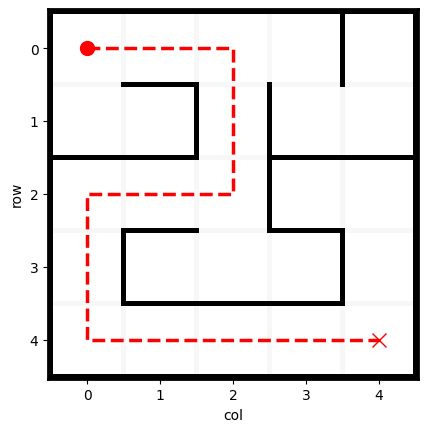

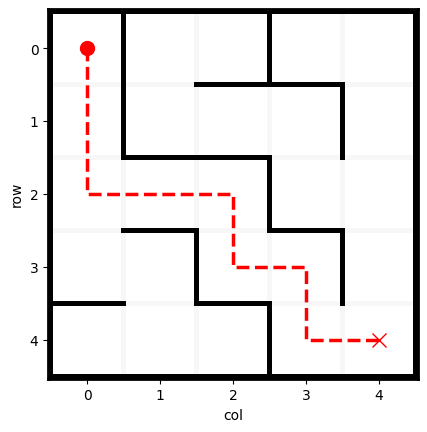

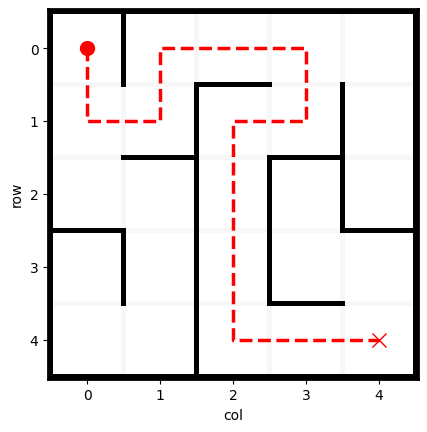

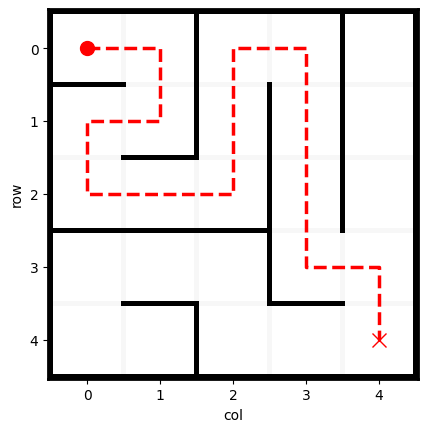

In [61]:
from maze_dataset.plotting import MazePlot
for maze in dataset:
    MazePlot(maze).plot()

# MDP로 변환

In [67]:
from typing import Dict, Tuple
import numpy as np

# MDP를 구성할 때 사용할 액션(상하좌우)
ACTIONS = {
    "UP":    (-1, 0),
    "DOWN":  (1, 0),
    "LEFT":  (0, -1),
    "RIGHT": (0, 1),
}

def create_mdp_from_solved_maze(solved_maze):
    """
    maze_dataset의 SolvedMaze 객체(solved_maze)를 받아,
    각 격자를 상태, 상하좌우 이동을 행동으로 하는 MDP를 구성한다.
    """

    # 미로 크기: 예) (5, 5)
    grid_shape = solved_maze.grid_shape  # (n_row, n_col)
    
    # 도착 지점(목표) 좌표 (예: (grid_n-1, grid_n-1)에 해당)
    # SolvedMaze 내부에 end_pos가 있으므로 그대로 사용 가능
    #   - 만약 None이면, 따로 설정해주거나 임의로 정해야 함
    goal_coord = tuple(solved_maze.end_pos.tolist()) if solved_maze.end_pos is not None else None
    
    # --- MDP 구성요소 ---
    # 1. 상태 공간 (states)
    # 2. 행동 공간 (actions) - 여기서는 상하좌우 4가지
    # 3. 전이함수 transition: T(s,a) -> s'
    # 4. 보상함수 reward: R(s,a,s')
    # ------------------------------------------------

    # 각 상태에서 {행동: (다음 상태, 전이확률, 보상)} 구조를 저장하는 딕셔너리
    # 딕셔너리 구조 예시:
    # mdp[(r,c)] = {
    #   "UP":    [((r-1, c), 1.0, 0.0)],     # 리스트 형태(확률적 MDP 일반화)
    #   "DOWN":  [((r+1, c), 1.0, 0.0)],
    #   "LEFT":  [((r, c-1), 1.0, 0.0)],
    #   "RIGHT": [((r, c+1), 1.0, 0.0)]
    # }
    mdp = {}

    # 모든 격자 좌표(상태)를 순회
    for row in range(grid_shape[0]):
        for col in range(grid_shape[1]):
            current_state = (row, col)
            mdp[current_state] = {}

            # 미로 상의 실제 연결관계를 확인
            # SolvedMaze는 LatticeMaze를 상속하며, get_coord_neighbors() 메서드로
            # 현재 좌표에서 연결된(벽이 없는) 이웃 좌표를 얻을 수 있음.
            neighbors = solved_maze.get_coord_neighbors(
                np.array([row, col], dtype=np.int8)
            )
            # neighbors는 [[r1, c1], [r2, c2], ...] 형태 (ndarray)

            # 4방향 액션 각각 확인
            for action_name, (dr, dc) in ACTIONS.items():
                next_r = row + dr
                next_c = col + dc
                next_state = (next_r, next_c)

                # 기본 값: 이동 불가능(벽이 있거나 범위 밖) → 상태전이 없음
                # 이동 가능한 경우(미로에서 연결되어 있는 경우)에만 추가
                mdp[current_state][action_name] = []

                # 범위를 벗어나지 않고, 실제 미로에서 연결되어 있으면 이동 가능
                if 0 <= next_r < grid_shape[0] and 0 <= next_c < grid_shape[1]:
                    if [next_r, next_c] in neighbors.tolist():
                        # 보상 설계:
                        #  - 예) goal_coord(끝지점) 도달 시 +1, 그 외 0
                        reward = 0.0
                        if goal_coord is not None and (next_r, next_c) == goal_coord:
                            reward = 1.0
                        # 결정적 이동: 전이확률 = 1.0
                        transition_prob = 1.0

                        # MDP에 액션 결과 등록
                        mdp[current_state][action_name].append(
                            (next_state, transition_prob, reward)
                        )
                    else:
                        # 벽이 가로막힌 상태 → 이동 불가능 (transitions 없음)
                        pass
                # else: 범위 바깥 → 이동 불가능

    return mdp

# -----------------------------------------------------------------
# 예시 사용
# -----------------------------------------------------------------
if __name__ == "__main__":
    from maze_dataset import MazeDataset, MazeDatasetConfig
    from maze_dataset.generation import LatticeMazeGenerators

    # 1) 간단한 DFS 미로 생성
    cfg = MazeDatasetConfig(
        name="mdp_test",
        grid_n=5,
        n_mazes=1,  # 하나만 생성
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
        # 예시: 시작 (0,0), 끝 (4,4) 고정
        endpoint_kwargs=dict(
            allowed_start=[(0, 0)],
            allowed_end=[(4, 4)],
        )
    )

    dataset = MazeDataset.from_config(cfg)
    solved_maze = dataset[0]
    print("ASCII maze:\n", solved_maze.as_ascii(show_endpoints=True))

    # 2) MDP 변환
    mdp_dict = create_mdp_from_solved_maze(solved_maze)

    # 3) 예시로, (0,0) 상태의 가능한 action들을 출력
    print("\nMDP transitions from state (0,0):")
    for action, outcomes in mdp_dict[(0,0)].items():
        # outcomes는 리스트: [(next_state, prob, reward), ...]
        print(f"  Action '{action}' -> {outcomes}")


ASCII maze:
 ###########
#SXXXX  # #
# ###X# # #
#   #X#   #
#####X#####
#XXXXX#   #
#X### ### #
#X#     # #
#X####### #
#XXXXXXXXE#
###########

MDP transitions from state (0,0):
  Action 'UP' -> []
  Action 'DOWN' -> [((1, 0), 1.0, 0.0)]
  Action 'LEFT' -> []
  Action 'RIGHT' -> [((0, 1), 1.0, 0.0)]


In [69]:
def print_possible_actions(mdp):
    """
    mdp[state][action] = [(next_state, prob, reward), ...] 형태를 받아
    각 state에서 가능한 action들을 텍스트로 출력.
    """
    for state in sorted(mdp.keys()):
        # 가능한 action = 실제로 next_state가 존재하는 action
        possible_actions = []
        for action, transitions in mdp[state].items():
            if len(transitions) > 0:
                possible_actions.append(action)
        print(f"State {state} => Actions: {possible_actions}")


In [70]:
import networkx as nx

def mdp_to_nx_digraph(mdp):
    """
    MDP 딕셔너리를 NetworkX DiGraph로 변환.
    노드: state (row, col)
    간선: state -> next_state
        - edge 데이터: {'action': action_name, 'prob': transition_prob, 'reward': reward}
    """
    G = nx.DiGraph()
    
    for state, action_dict in mdp.items():
        # 노드 추가
        G.add_node(state)
        for action_name, transitions in action_dict.items():
            for (next_state, prob, reward) in transitions:
                # 확률(prob)이 0 이상인 경우만 실제 간선으로 추가
                if prob > 0:
                    G.add_edge(
                        state,
                        next_state,
                        action=action_name,
                        prob=prob,
                        reward=reward
                    )
    return G


In [71]:
import matplotlib.pyplot as plt

def draw_mdp_graph(G, grid_shape):
    """
    2D 격자로 구성된 MDP를 NetworkX로 시각화.
    - 노드 위치: (col, -row)
    - 에지에 액션 이름(label)을 표시
    """
    # (row, col)을 (x=col, y=-row) 위치로 매핑
    pos = {}
    for r in range(grid_shape[0]):
        for c in range(grid_shape[1]):
            pos[(r,c)] = (c, -r)  # x=c, y=-r
    
    plt.figure(figsize=(8, 6))
    
    # 노드 그리기
    nx.draw_networkx_nodes(G, pos=pos, node_size=400, node_color='lightblue')
    nx.draw_networkx_labels(G, pos=pos, font_size=10, font_color='black')

    # 에지 그리기 (화살표 표시)
    nx.draw_networkx_edges(G, pos=pos, arrows=True, arrowstyle='->')

    # 에지 라벨 (action)
    edge_labels = {(u, v): d['action'] 
                   for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, font_size=8)

    plt.axis("off")
    plt.title("MDP Graph: States and Actions")
    plt.tight_layout()
    plt.show()


State (0, 0) => Actions: ['DOWN']
State (0, 1) => Actions: ['DOWN']
State (0, 2) => Actions: ['DOWN']
State (1, 0) => Actions: ['UP', 'DOWN']
State (1, 1) => Actions: ['UP', 'RIGHT']
State (1, 2) => Actions: ['UP', 'DOWN', 'LEFT']
State (2, 0) => Actions: ['UP', 'RIGHT']
State (2, 1) => Actions: ['LEFT', 'RIGHT']
State (2, 2) => Actions: ['UP', 'LEFT']


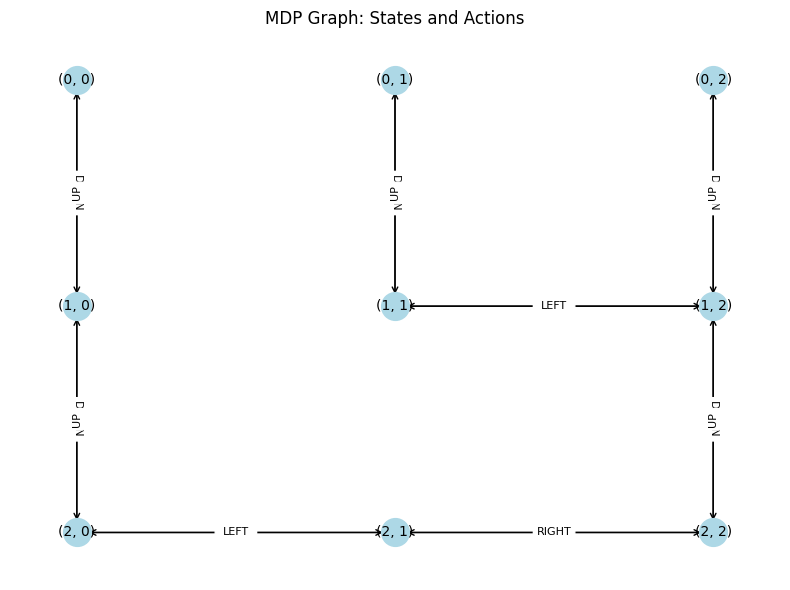

In [72]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from maze_dataset import MazeDataset, MazeDatasetConfig
    from maze_dataset.generation import LatticeMazeGenerators

    # 1) 작은 미로 생성 (ex: 3x3)
    cfg = MazeDatasetConfig(
        name="mdp_graph_example",
        grid_n=3,
        n_mazes=1,
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
        endpoint_kwargs=dict(
            allowed_start=[(0, 0)],
            allowed_end=[(2, 2)],
        )
    )
    dataset = MazeDataset.from_config(cfg)
    solved_maze = dataset[0]

    # 2) MDP 구성
    mdp = create_mdp_from_solved_maze(solved_maze)
    
    # 텍스트 형태로 가능한 액션 출력
    print_possible_actions(mdp)

    # 3) NetworkX로 그래프 구성 및 시각화
    G = mdp_to_nx_digraph(mdp)
    draw_mdp_graph(G, grid_shape=solved_maze.grid_shape)
